$\newcommand{\ENC}{\text{ENC}}$
$\newcommand{\DEC}{\text{DEC}}$
$\newcommand{\similarity}{\text{similarity}}$


**After this laboratory you should be able to**
- Explain what an **embedding** is and the motivation for it
- Explain the **encoder-decoder paradigm**
- Understand SVD and **Random walk embeddings**
- Explore Spectral embeddings
- Explore Graph embeddings
- Read the papers provided

In [3]:
import networkx as nx
import numpy as np
import pandas as pd
import scipy
from scipy.io import mmread
import scipy.stats as st
import matplotlib.pyplot as plt
import itertools
import os, sys
import urllib.request
import io
import zipfile
import random
from tqdm import tqdm


# Might be worth to take a look at this https://github.com/sknetwork-team/scikit-network


## Library 
We are going to use https://karateclub.readthedocs.io/en/latest/ library for most of the algorithms

## Utils

In [5]:
parent_dir = os.path.abspath(os.path.join('..'))
if not parent_dir in sys.path:
    sys.path.append(parent_dir)
    
from utils.utils import average_clustering, average_degree, connectivity_perc, giant_component, communities_to_dict, dict_to_communities

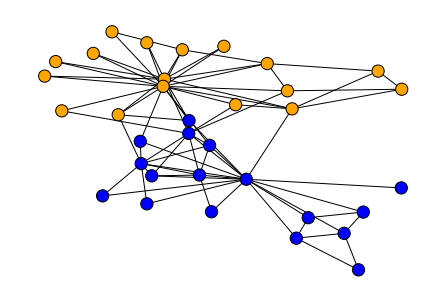

In [6]:
# Load karate

G_karate = nx.karate_club_graph()
karate_color = ['blue' if club == 'Mr. Hi' else 'orange' for club in list(nx.get_node_attributes(G_karate, 'club').values())]
nx.draw_spring(G_karate, node_color = karate_color, node_size = 150, edgecolors = 'black')

In [7]:
# Load football

url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"

sock = urllib.request.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read("football.txt").decode()  # read info file
gml = zf.read("football.gml").decode()  # read gml data
# throw away bogus first line with # from mejn files
gml = gml.split("\n")[1:]
G_football = nx.parse_gml(gml)  # parse gml data

In [8]:
G_football = nx.relabel_nodes(G_football, {k: v for k, v in zip(G_football.nodes,range(len(G_football.nodes)))})

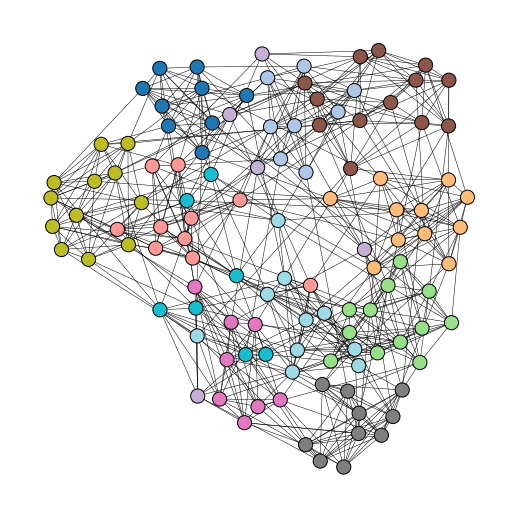

In [9]:
plt.figure(figsize = (7, 7))
pos = nx.spring_layout(G_football, k = 2, iterations=1000)
football_color = list(nx.get_node_attributes(G_football, 'value').values())
nx.draw(G_football, pos = pos, node_size = 200, width = .5, edgecolors = 'black', node_color = football_color, cmap = plt.cm.tab20)

,nodes,label
0,1,3
1,2,6
2,3,5
3,4,5
4,5,4


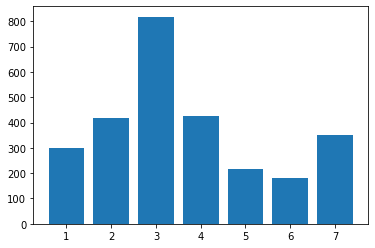

Graph with 2485 nodes and 5069 edges


In [10]:
# Load cora
G_cora =  nx.read_weighted_edgelist(os.path.join('..', 'data', 'cora.edges'), delimiter=',')


df = pd.read_csv(os.path.join('..', 'data', 'cora.node_labels'), delimiter=',', names = ['nodes', 'label'])
display(df.head())
plt.bar(*np.unique(df['label'], return_counts = True))
plt.show()

d = {str(k): {'label': v} for k, v in zip(df['nodes'], df['label'])}
nx.set_node_attributes(G_cora, d)

G_cora = giant_component(G_cora)
print(G_cora)

G_cora = nx.relabel_nodes(G_cora, {k: v for k, v in zip(G_cora.nodes,range(len(G_cora.nodes)))})
cora_color =list(nx.get_node_attributes(G_cora, 'label').values())

# Embeddings

**Motivations/ task**
1. Basic  ML models work simple data types:
    Images are 2d grids, text to speech is 1d, tabular data is ... tabular.  
    Graphs have variable nodes, variable edges, no reference point (what is top left, what is top right in a graph?)  
    What about an adjacency matrix? If you want to feed an adjacency matrix into a network there will be issues. Can you think of a few?.  
    We want to compress graph features into an $\mathbb R^d$ dimensional space
2. We can train **graph encoders** to extract features better than we can. 

*Intuition*:
- Similarity of embeddings between nodes = similarity in their networks. Ex: both nodes are "close" in the network in some sense (connected with an edge)

**Types of embeddings**
- Node embeddings
- Edge embeddings
- Graph embeddings



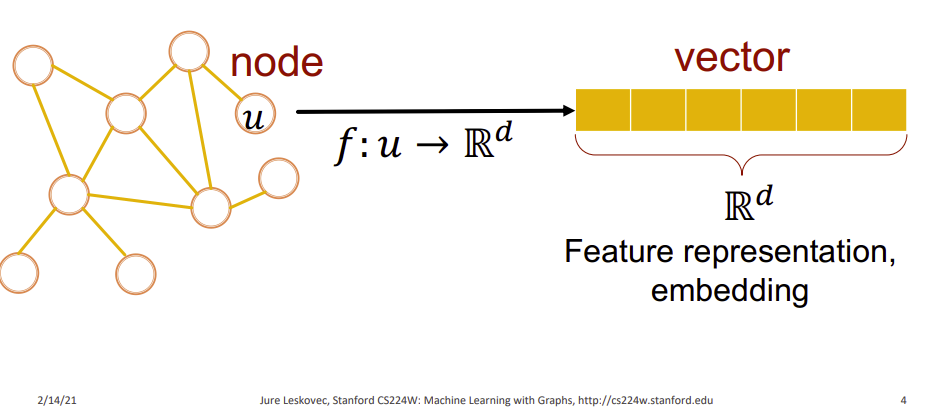

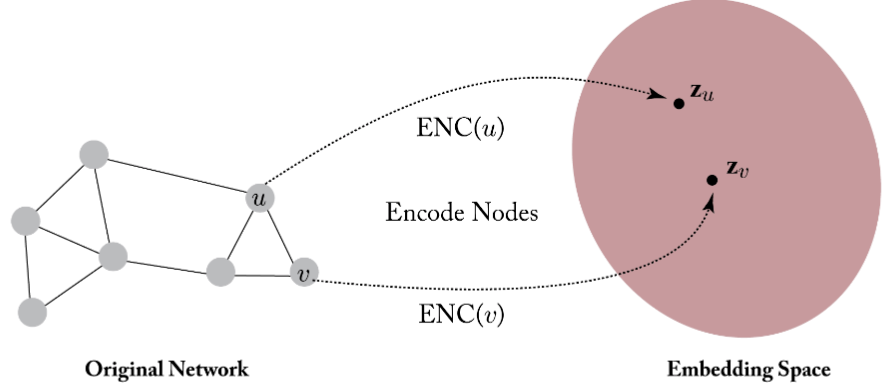

# Encoder-decoder paradigm

Let $G$ be a graph with nodes in $V$ and edges in $E$ and with the adj matrix $A$.  
Let $u \in V$ be a node in $G$ and $z_u \in \mathbb R^d$ its $d$ dimensional embedding

**Goal**: Learn encoder-decoders such that when encoded the nodes are closed together

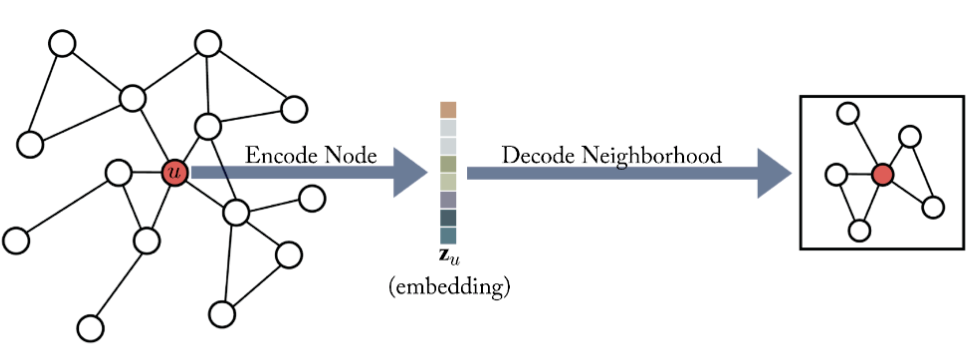

## Encoder
$$\ENC: V \to \mathbb R^d$$

Example  
**Shallow embeddings -- Embedding lookup**
$$\ENC(u) = Z[u]$$ 
where $Z \in \mathbb R^{|V| \times d}$ is a matrix containing the embedding vectors for all nodes and $Z[u]$ denotes
the row of $Z$ corresponding to node $v$.

The goal would be to learn the matrix $Z$ -- Intensive to compute, easy to lookup

**Remark**
- This is a **shallow encoder** (it's just a lookup). There are encoders that use *node features* and the *local graph structure* to generate embeddings. These generalized encoder architectures are called **Graph Neural Networks**

## Decoder
Will be based on the node similarity function. The standard practice is to define *pairwise decoders* that predict similarity between nodes

$$\DEC : \mathbb R^d \times R^d \to R$$

with the desired property:
$$ \DEC(\ENC(u), \ENC(v) = \DEC(z_u, z_v) \approx \similarity(u, v)$$

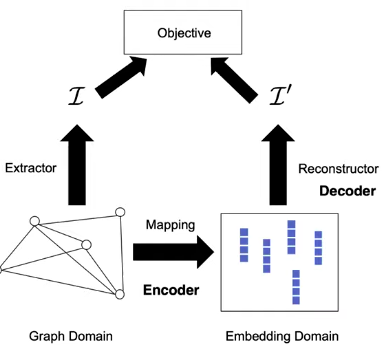

## Node similarity function
**Similarity function**  
Specifies how the relationships in the vector space map to the relationships in the original network

$$\similarity(u, v) \approx z_v^T z_u$$
Intuition for dot product: if 2 nodes embeddings are "perpendicular" their dot product is $0$

**How to define the similarity?**  
There are many ways to define similarities. Are the nodes linked? Do they share neighbours?. 

## Limitations of shallow embeddings

1. A shallow embedding does not share parameters between nodes in the encoder (the encoder directly optimizes a unique embedding vector for each node) => Statistically and computationally inneficient. The number of parameters in a shallow embedding grows with the number of nodes
2. Does not leverage node features in the encoder.
3. *Transitive methods* -- Can only generate embeddings for nodes that were present during the training phase. New embeddings are not possible unless additional optimizations are performed to learn the embeddings => We can't generalize.
4. Cannot capture structural similarity (Except anonymous walks, will be discussed later)

# SVD / PCA embeddings

$$A = U \cdot S \cdot V^T$$
SVD reminder
- https://en.wikipedia.org/wiki/Singular_value_decomposition
- https://www.youtube.com/watch?v=gXbThCXjZFM&list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv&index=1 -- watch few vids from here

SVD decomposition can be interpreted as an embedding. The space is given by the $U$ matrix, $V^T$ are coordinates in $U$ and $S$ represents some scaling factor. If we are taking a few columns from $U$ then we can approximate the matrix $A$

In [9]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.utils.extmath import svd_flip
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from umap import UMAP

In [10]:
A = nx.to_numpy_array(G_karate)
A = nx.to_numpy_array(G_football)
#A = nx.to_numpy_array(G_cora)

In [11]:
#U, S, Vt = np.linalg.svd(A, full_matrices=False)
U, S, Vt = scipy.sparse.linalg.svds(A, k = 2)
S = S[::-1]
U, Vt = svd_flip(U[:, ::-1], Vt[::-1])

In [12]:
np.all(np.isclose(U @ np.diag(S) @ Vt, A))

False

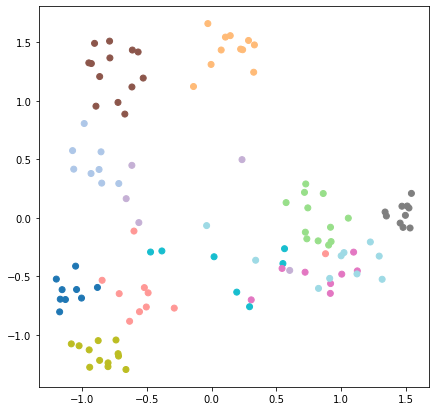

In [13]:

# emb = A @ Vt.T
# emb = np.array(emb.T) # Transform from matrix to array for scatter

#emb = TruncatedSVD(n_components=2).fit_transform(A).T
emb = PCA(n_components=2).fit_transform(A).T
plt.figure(figsize = (7, 7))
plt.scatter(*emb, c = football_color, cmap = plt.cm.tab20)

# Random walks embeddings

Relevant papers

[deepwalk paper](https://arxiv.org/pdf/1403.6652.pdf) -- read it  
[node2vec paper](https://arxiv.org/pdf/1607.00653.pdf)  
[Random walks as matrix factorization](https://arxiv.org/pdf/1710.02971.pdf)

Goal: Find $z_u$ -- the embedding of $u$

*Intuition*:  
Estimate probability of visiting a node $v$ on a random walk starting from node $u$ using a random strategy $R$ -- we want to estimate $P_R(v | u)$.  
If the nodes are *closer* they will get visited multiple times. Therefore if we have a high $P_R(v | u)$ we want a big $z_v^Tz_u$

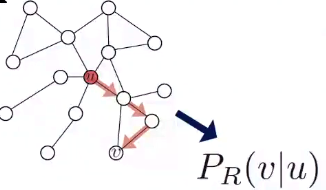

Algorithm
1. Run random walks
2. For each node $u$ look at the neighbourhood generated by ranom walks starting from $u$-- $N_R(u)$
3. Form an optimization problem that you can iteratively solve using SGD. Minimze the following:
$$\mathcal L = \sum_{u \in V}\sum_{v\in N_r(u)} -\log(P(v|z_u))$$

**Random walk**  
Given a graph and a starting point we select a neighbour of it at random and move to the neighbour. We repeat a given number of steps.

**Walking strategy $R$**
- You can go randomly
- **node2vec**: You can go DFS or BFS to get a micro neighbourhood view or a macro neighbourhood view. Parametrize it with 2 parameters $p$ -- probability to return to previous node -- and $q$ -- ratio between DFS and BFS

In [14]:
from karateclub import DeepWalk, Walklets, Node2Vec

In [15]:
#?DeepWalk

In [16]:
#dw = DeepWalk(walk_number=100, walk_length=30, window_size=5, dimensions = 4) # For football
dw = DeepWalk(walk_number=10, walk_length=30, window_size=10, dimensions = 16)
dw.fit(G_cora)
emb = dw.get_embedding()

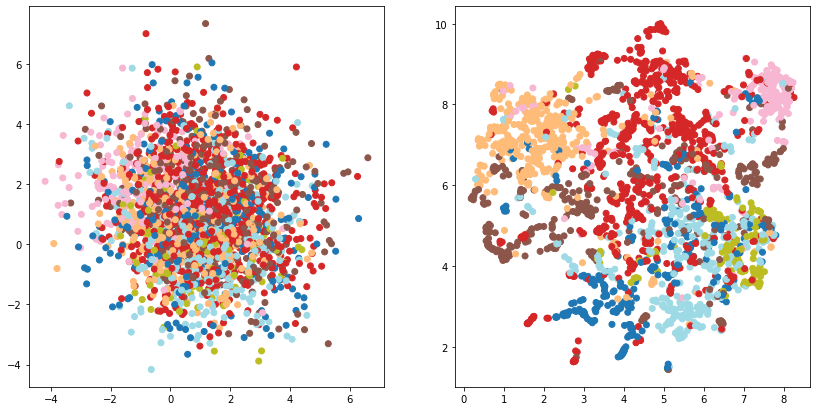

In [18]:
plt.figure(figsize = (14, 7))
plt.subplot(1, 2, 1)
plt.scatter(*emb[:, 0:2].T, c = cora_color, cmap = plt.cm.tab20)

# Try to pca the embeddings
plt.subplot(1, 2, 2)
#plt.scatter(*PCA(n_components=2).fit_transform(emb).T, c = cora_color, cmap = plt.cm.tab20)
#plt.scatter(*TSNE(n_components=2).fit_transform(emb).T, c = cora_color, cmap = plt.cm.tab20)
plt.scatter(*UMAP(n_components=2).fit_transform(emb).T, c = cora_color, cmap = plt.cm.tab20)


plt.show()

In [19]:
walklets = Walklets(walk_number=10, walk_length=30, window_size=10, dimensions = 16) 
#walklets = Walklets(walk_number=100, walk_length=30, window_size=4, dimensions = 4) # for football
walklets.fit(G_cora)
emb = walklets.get_embedding()

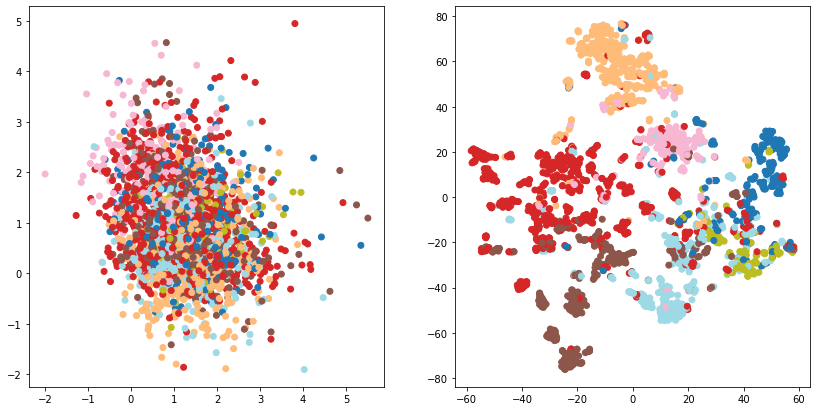

In [21]:
plt.figure(figsize = (14, 7))
plt.subplot(1, 2, 1)
plt.scatter(*emb[:, 0:2].T, c = cora_color, cmap = plt.cm.tab20)

# Try to pca the embeddings
plt.subplot(1, 2, 2)
#plt.scatter(*PCA(n_components=2).fit_transform(emb).T, c = cora_color, cmap = plt.cm.tab20)
plt.scatter(*TSNE(n_components=2).fit_transform(emb).T, c = cora_color, cmap = plt.cm.tab20)
#plt.scatter(*UMAP(n_components=2).fit_transform(emb).T, c = cora_color, cmap = plt.cm.tab20)

plt.show()

# Spectral embedding

**Laplacian matrix**  
https://en.wikipedia.org/wiki/Laplacian_matrix

$$L = D - A$$
where $A$ is the adjacencty matrix and $D$ is the [degree matrix](https://en.wikipedia.org/wiki/Degree_matrix) (a diagonal matrix with the node's degree)

There is a normalized version
$$N = D^{-1/2}LD^{-1/2}$$



In [22]:
from karateclub import LaplacianEigenmaps

In [23]:
print(nx.laplacian_matrix(G_karate).todense())

[[16 -1 -1 ... -1  0  0]
 [-1  9 -1 ...  0  0  0]
 [-1 -1 10 ...  0 -1  0]
 ...
 [-1  0  0 ...  6 -1 -1]
 [ 0  0 -1 ... -1 12 -1]
 [ 0  0  0 ... -1 -1 17]]


In [24]:
print(nx.normalized_laplacian_matrix(G_karate).todense())

[[ 1.         -0.08333333 -0.07905694 ... -0.10206207  0.
   0.        ]
 [-0.08333333  1.         -0.10540926 ...  0.          0.
   0.        ]
 [-0.07905694 -0.10540926  1.         ...  0.         -0.09128709
   0.        ]
 ...
 [-0.10206207  0.          0.         ...  1.         -0.11785113
  -0.09901475]
 [ 0.          0.         -0.09128709 ... -0.11785113  1.
  -0.070014  ]
 [ 0.          0.          0.         ... -0.09901475 -0.070014
   1.        ]]


In [25]:
print(nx.laplacian_spectrum(G_karate))

[-9.49934576e-15  4.68525227e-01  9.09247664e-01  1.12501072e+00
  1.25940411e+00  1.59928308e+00  1.76189862e+00  1.82605521e+00
  1.95505045e+00  2.00000000e+00  2.00000000e+00  2.00000000e+00
  2.00000000e+00  2.00000000e+00  2.48709173e+00  2.74915718e+00
  3.01396297e+00  3.24206748e+00  3.37615409e+00  3.38196601e+00
  3.47218740e+00  4.27587682e+00  4.48000767e+00  4.58079267e+00
  5.37859508e+00  5.61803399e+00  6.33159222e+00  6.51554463e+00
  6.99619703e+00  9.77724095e+00  1.09210675e+01  1.33061223e+01
  1.70551712e+01  1.81366960e+01]


In [26]:
#le = LaplacianEigenmaps(dimensions=8) # for football
le = LaplacianEigenmaps(dimensions=16)
le.fit(G_cora)
emb = le.get_embedding()

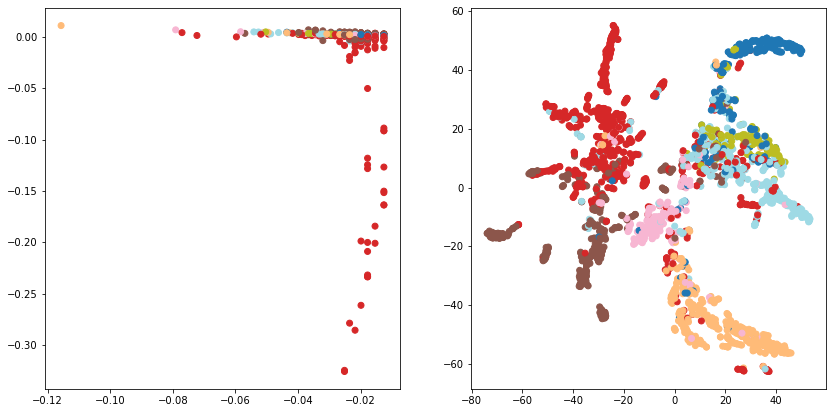

In [28]:
plt.figure(figsize = (14, 7))
plt.subplot(1, 2, 1)
plt.scatter(*emb[:, 0:2].T, c = cora_color, cmap = plt.cm.tab20)

# Try to pca the embeddings
plt.subplot(1, 2, 2)
#plt.scatter(*PCA(n_components=2).fit_transform(emb).T, c = cora_color, cmap = plt.cm.tab20)
plt.scatter(*TSNE(n_components=2).fit_transform(emb).T, c = cora_color, cmap = plt.cm.tab20)
#plt.scatter(*UMAP(n_components=2).fit_transform(emb).T, c = cora_color, cmap = plt.cm.tab20)

plt.show()

# Evaluating an embedding

We will train a classifier on the embeddings and evaluate it against the labels

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [48]:
def eval_emb(X, y, model, test_sizes):
    scores = []
    for size in test_sizes:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size, random_state = 42)
        model.fit(X_train, y_train)
        scores.append(accuracy_score(model.predict(X_test), y_test))
    return scores
        
        

In [54]:
y = cora_color
test_sizes = [.9, .8, .7, .5, .2]
algorithms = [
    DeepWalk(walk_number=10, walk_length=30, window_size=10, dimensions = 16),
    Walklets(walk_number=10, walk_length=30, window_size=10, dimensions = 16) ,
    LaplacianEigenmaps(dimensions=16)
]

algo_scores = []
for algo in tqdm(algorithms):
    model = GradientBoostingClassifier(random_state=42)
    algo.fit(G_cora)
    emb = algo.get_embedding()
    scores = eval_emb(emb, y, model, test_sizes)
    algo_scores.append(scores)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:26<00:00, 48.97s/it]


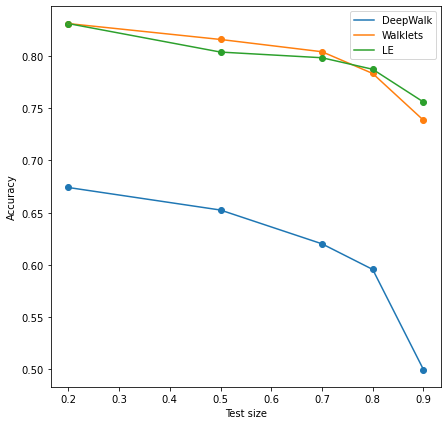

In [56]:
labels = ['DeepWalk', 'Walklets', 'LE']
plt.figure(figsize = (7, 7))
for label, scores in zip(labels, algo_scores):
    plt.plot(test_sizes, scores, label = label)
    plt.scatter(test_sizes, scores)

plt.ylabel("Accuracy")
plt.xlabel("Test size")
plt.legend()

# Graph embeddings

1. Average node embeddings
2. Cluster some nodes into super-nodes and run random walks on them
3. [Anonymous walks](https://arxiv.org/pdf/1805.11921.pdf) -- Consider all possible walk **sequences** independend of nodes when running walks. Make a probability distribution over them. That leads to an embedding of the graph. We can learn an embedding for each possible anonymous walk and then learn an embedding for the graph G